Unsupervised learning means a lack of labels: we are looking for structure in the data, without having an *a priori* intuition what that structure might be. A great example is clustering, where the goal is to identify instances that clump together in some high-dimensional space. Unsupervised learning in general is a harder problem. Deep learning revolutionized supervised learning and it had made significant advances in unsupervised learning, but there remains plenty of room for improvement. In this notebook, we look at how we can map an unsupervised learning problem to graph optimization, which in turn we can solve on a quantum computer.

# Mapping clustering to discrete optimization

Assume that we have some points $\{x_i\}_{i=1}^N$ lying in some high-dimensional space $\mathbb{R}^d$. How do we tell which ones are close to one another and which ones are distant? To get some intuition, let's generate a simple dataset with two distinct classes. The first five instances will belong to class 1, and the second five to class 2:

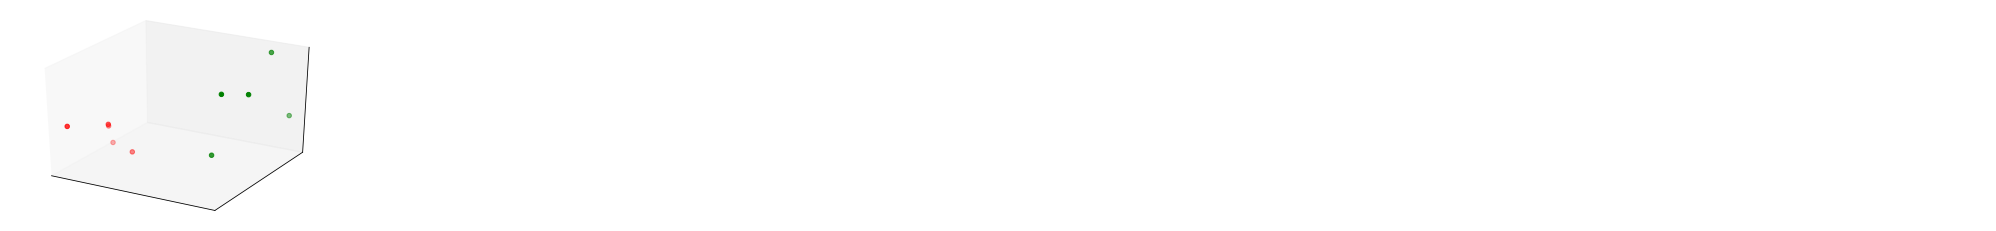

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

n_instances = 10
class_1 = np.random.rand(n_instances//2, 3)/5
class_2 = (0.6, 0.1, 0.05) + np.random.rand(n_instances//2, 3)/5
data = np.concatenate((class_1, class_2))
colors = ["red"] * (n_instances//2) + ["green"] * (n_instances//2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', xticks=[], yticks=[], zticks=[])
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=colors);

The high-dimensional space is endowed with some measure of distance, the Euclidean distance being the simplest case. We can calculate all pairwise distances between the data points:

In [2]:
import itertools
w = np.zeros((n_instances, n_instances))
for i, j in itertools.product(*[range(n_instances)]*2):
    w[i, j] = np.linalg.norm(data[i]-data[j])

This matrix is sometimes called the Gram or the kernel matrix. The Gram matrix contains a fair bit of information about the topology of the points in the high-dimensional space, but it is not easy to see. We can think of the Gram matrix as the weighted adjacency matrix of a graph: two nodes represent two data instances. Their distance as contained in the Gram matrix is the weight on the edge that connects them. If the distance is zero, they are not connected by an edge. In general, this is a dense graph with many edges -- sparsity can be improved by a distance function that gets exponentially smaller.

What can we do with this graph to find the clusters? We could look for the max-cut, that is, the collection of edges that would split the graph in exactly two if removed, while maximizing the total weight of these edges. This is a well-known NP-hard problem, but it also very naturally maps to an Ising model.

The spin variables $\sigma_i \in \{-1, +1\}$ take on value $\sigma_i = +1$ if a data instance is in cluster 1 (nodes $V_1$ in the graph), and $\sigma_i = -1$ if the data instance is in cluster 2 (nodes $V_2$ in the graph). The cost of a cut is

$$
\sum_{i\in V_1, j\in V_2} w_{ij}
$$

Let us assume a fully connected graph. Then, accounting for the symmetry of the adjacency matrix, we can expand this as
$$
\frac{1}{4}\sum_{i, j} w_{ij} - \frac{1}{4} \sum_{i, j} w_{ij} \sigma_i \sigma_j
$$
$$
= \frac{1}{4}\sum_{i, j\in V} w_{ij} (1- \sigma_i \sigma_j).
$$                 

By taking the negative of this, we can directly solve the problem by a quantum optimizer.

# Solving the max-cut problem by QAOA

Most quantum computing frameworks have convenience functions defined for common graph optimization algorithms, and max-cut is a staple. This reduces our task to importing the relevant functions:

In [6]:
from qiskit_aqua import get_algorithm_instance, get_optimizer_instance
from qiskit_aqua.input import get_input_instance
from qiskit_aqua.translators.ising import maxcut

Setting $p=1$ in the QAOA algorithm, we can initialize it with the max-cut problem.

In [7]:
qubit_operators, offset = maxcut.get_maxcut_qubitops(w)
p = 1
qaoa = get_algorithm_instance('QAOA.Variational')
qaoa.setup_quantum_backend(shots=100)
optimizer = get_optimizer_instance('COBYLA')
qaoa.init_args(qubit_operators, 'matrix', p, optimizer)

Here the choice of the classical optimizer `COBYLA` was arbitrary. Let us run this and analyze the solution. This can take a while on a classical simulator.

In [ ]:
result = qaoa.run()
x = maxcut.sample_most_likely(result['eigvecs'][0])
graph_solution = maxcut.get_graph_solution(x)
print('energy:', result['energy'])
print('maxcut objective:', result['energy'] + offset)
print('solution:', maxcut.get_graph_solution(x))
print('solution objective:', maxcut.maxcut_value(x, w))

Looking at the solution, the cut matches the clustering structure.

# Solving the max-cut problem by annealing

Naturally, the same problem can be solved on an annealer. Our only task is to translate the couplings and the on-site fields to match the programming interface:

In [5]:
import dimod

J, h = {}, {}
for i in range(n_instances):
    h[i] = 0
    for j in range(i+1, n_instances):
        J[(i, j)] = w[i, j]

model = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=10)
print("Energy of samples:")
for solution in response.data():
    print("Energy:", solution.energy, "Sample:", solution.sample)

Energy of samples:
Energy: -12.93414334894842 Sample: {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}
Energy: -12.93414334894842 Sample: {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}
Energy: -12.93414334894842 Sample: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1}
Energy: -12.93414334894842 Sample: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1}
Energy: -12.93414334894842 Sample: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1}
Energy: -12.93414334894842 Sample: {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}
Energy: -12.93414334894842 Sample: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1}
Energy: -12.93414334894842 Sample: {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}
Energy: -12.93414334894842 Sample: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: -1, 6: -1, 7: -1, 8: -1, 9: -1}
Energy: -12.93414334894842 Sample: {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5

If you look at the first sample, you will see that the first five data instances belong to the same graph partition, matching the actual cluster.

# References

[1] Otterbach, J. S., Manenti, R., Alidoust, N., Bestwick, A., Block, M., Bloom, B., Caldwell, S., Didier, N., Fried, E. Schuyler, Hong, S., Karalekas, P., Osborn, C. B., Papageorge, A., Peterson, E. C., Prawiroatmodjo, G., Rubin, N., Ryan, Colm A., Scarabelli, D., Scheer, M., Sete, E. A., Sivarajah, P., Smith, Robert S., Staley, A., Tezak, N., Zeng, W. J., Hudson, A., Johnson, Blake R., Reagor, M., Silva, M. P. da, Rigetti, C. (2017). [Unsupervised Machine Learning on a Hybrid Quantum Computer](https://arxiv.org/abs/1712.05771). *arXiv:1712.05771*.